Visualize with a Gaussian density profile
===

In [40]:
# Importing usefull tools

from numpy import *
import matplotlib.pyplot as plt
import profile

In [41]:
# Usefull functions

def gauss(x,sigma,mean = 0): return exp(-(x-mean)**2/(2*sigma**2))/(sqrt(2*pi)*sigma)
def volume(R): return 4/3 * pi * R**3
def mass(rho): return 4 * pi * sum(rho * r**2 * dr)
def sec_to_year(s): return s / 3600 / 24 / 365

def plot(mod,r,res,theo=None):
    _,ax1 = plt.subplots()
    l1 = ax1.plot(r,res,'bx',label="Code results")
    ax1.set_xlabel("r [cm]")
    ax1.set_label("Density [g.cm-3]")
    lns = l1

    if theo is not None:
        ax2 = ax1.twinx()
        l2 = ax2.plot(r,theo,'r',label="Analytic results")
        ax2.set_xlabel("r [cm]")

        if mod.lower()=="density":
            ax2.set_label("Density [g.cm-3]")
        elif mod.lower()=="speed":
            ax2.set_label("Speed [cm.s-1]")
        lns = l1+l2

    # added these three lines
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    if mod.lower()=="density":
        plt.title("Density profile")
    elif mod.lower()=="speed":
        plt.title("Speed profile")

    plt.grid()
    plt.show()

In [42]:
# Declaring constants

kb = 1.3806503e-16
Na = 6.022e23
mH = 1.67262178e-27
G = 6.67408e-8
Msun = 2e33
parsec_to_cm = 3.08567758e18
mu = 1.4
Temp = 10 # [K]
cs = sqrt(kb * Temp / (mu * mH))
rho_0 = Msun / volume(0.1/2*parsec_to_cm)
tff = sqrt(3*pi/(32 * G * rho_0))

In [43]:
# Getting all generated data

try:
    rho = loadtxt("results/rho.dat")
    v   = loadtxt("results/v.dat")
    t   = loadtxt("results/time.dat")
    r   = loadtxt("results/space.dat")
except:
    raise NameError("You must run the 'main_test.f90' program first. \n Please run :\n - gfortran .\Constants.f90 .\Prestel.f90 .\main_test.f90\n - ./a.exe")

In [44]:
N = size(r)
sigma = N/2
dt = tff / (N-1)
dr = (r[-1] - r[0]) / (N-1)
print("tff =", round(sec_to_year(tff),2),"years")

tff = 184743.17 years


---
# Visualize with a Gaussian density profile

## Evolution

### State at $t_0$

We will focus the study on a spherical space of radius $R$ containing a gaz of mass $Msun$ (1 sun mass) with a density distribution at $t_0$ that have a gaussian shape:

$$D = \frac{1}{\sqrt{2\pi}\:\sigma} \exp\bigg(\frac{-r^2}{2\sigma^2}\bigg)$$

where $\sigma$ is the standard deviation defined arbitrarily to $\frac{R}{2}$.

To get the correct density distribution, we have to fit this shape with the desired mass (here, the mass of the sun), by normalizing this distribution over the volume and multiply by the mass.
$$\rho_0 = \frac{D}{\int_0^{2 \pi}\int_0^{\pi}\int_0^{R} D r^2 \sin(\theta) dr d\theta d\phi} * Msun$$

Here, we assume that our density only depend of the radius, so we can simplify:
$$\rho_0 = \frac{D}{4 \pi \int_0^{R} D r^2 dr} * Msun$$

For the speed distribution, in a first time, we assume that, at $t_0$, all the gas is static.

$$v_0 = 0$$

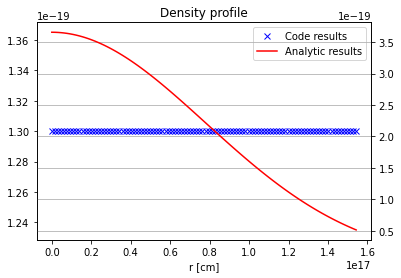

Integration of density on the sphere (to get the mass in sun mass unit)
Excpected:    1.0152025303540457
Analytic:     1.0000000000000002
Code result:  1.0152025000986535


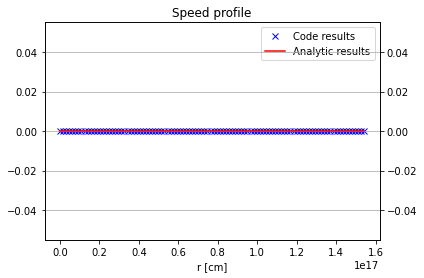

In [45]:
rho_theo = empty_like(rho)

distrib = gauss(arange(N),sigma)               # compute the gaussian distribution
P = Msun / mass(distrib)                       # average density in 1D
rho_theo[0] = distrib * P                      # compute the distribution of density to have the desired mass

plot("density",r,rho[0],rho_theo[0])

print("Integration of density on the sphere (to get the mass in sun mass unit)")
print("Excpected:   ", mass(Msun/volume(r[-1]))/Msun)
print("Analytic:    ", mass(rho_theo[0])/Msun)
print("Code result: ", mass(rho[0])/Msun)

v_theo = empty_like(v)
v_theo[0] = zeros(len(v_theo[0]))

plot("speed",r,v[0],v_theo[0])

### State at $t_1$

The evolution of the densities and the speeds are described by these relations:

$$\rho_{i+1} = \rho_i - \frac{1}{r^2}\bigg(\frac{\partial(r^2\rho v)}{\partial r}\bigg)_i dt + o(dt)$$
$$v_{i+1} = v_i + \bigg[-v_i\bigg(\frac{\partial v}{\partial r}\bigg)_i - \frac{c_s^2}{\rho_i}\bigg(\frac{\partial \rho}{\partial r}\bigg)_i - \int 4 \pi G \rho_i dr \bigg] dt + o(dt)$$

So we can deduce the expressions for the densities and the speeds at $t_1$:

$$\rho_{1} = \rho_0 - \frac{1}{r^2}\bigg(\frac{\partial(r^2\rho_0 v_0)}{\partial r}\bigg) dt$$
$$\rightarrow \rho_1 = \rho_0$$

$$v_{1} = v_0 + \bigg[-v_0\bigg(\frac{\partial v_0}{\partial r}\bigg) - \frac{c_s^2}{\rho_0}\bigg(\frac{\partial \rho_0}{\partial r}\bigg) - \int 4 \pi G \rho_0 dr \bigg] dt$$
$$\rightarrow v_1 = \bigg(\frac{c_s^2 r}{\sigma^2} - 4 \pi G\bigg) dt$$

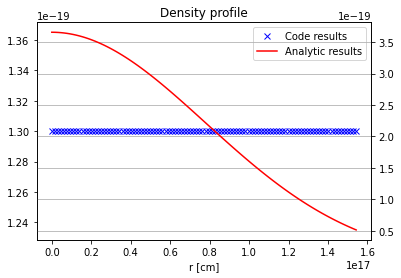

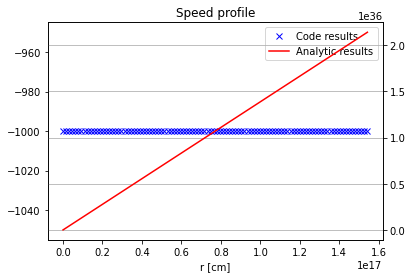

In [46]:
rho_theo[1] = rho_theo[0]
plot("density",r,rho[1],rho_theo[1])

v_theo[1] = (cs**2 * r / sigma**2 - P * 4 * pi * G) * dt
plot("speed",r,v[1],v_theo[1])

### State at $t_2$

$$\rho_2 = \rho_0 \Bigg(1 - dt^2 \bigg[cs^2 \bigg(3-\frac{r^2}{\sigma^2}\bigg) + 4 \pi G \bigg(\frac{r}{\sigma^2} - \frac{2}{r}\bigg)\bigg] \Bigg)$$
$$v_2 = v_1 (2-c_s^2 dt)$$

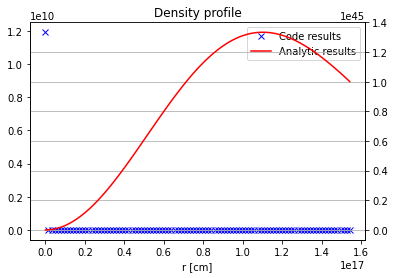

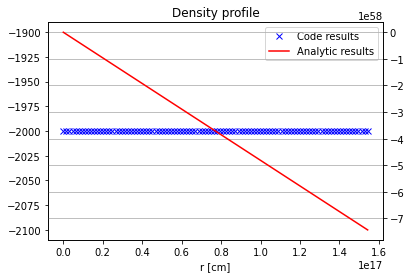

In [47]:
rho_theo[2] = rho_theo[0] * (1 - dt**2 * (cs**2*(3-r**2/sigma**2) + 4*pi*G*(r/sigma**2 - 2/r)))
plot("density",r,rho[2],rho_theo[2])

v_theo[2] = v_theo[1] * (2 - cs**2 * dt)
plot("density",r,v[2],v_theo[2])